In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

In [11]:
df_train = pd.read_csv('../data/ML.csv')
df_train = df_train[['Date', 'Freight_Price', 'Oil_Price', 'has_war', 'has_crisis']]
df_train["Date"] = pd.to_datetime(df_train["Date"], format="%Y-%m-%d")
df_train.sort_values("Date", inplace=True)
df_train.set_index("Date", inplace=True)
df_train.index.freq = 'MS'
df_train['month_sin'] = np.sin(2 * np.pi * df_train.index.month / 12)
df_train['month_cos'] = np.cos(2 * np.pi * df_train.index.month / 12)

# 2) Лаги для обучения (Freight_Price t-1,6,12,24 и Oil_Price аналогично)
for lag in [1, 6, 12, 24]:
    df_train[f'Freight_Price(t-{lag})'] = df_train['Freight_Price'].shift(lag)
    df_train[f'Oil_Price(t-{lag})'] = df_train['Oil_Price'].shift(lag)
df_train = df_train.dropna()
df_train

,Freight_Price,Oil_Price,has_war,has_crisis,month_sin,month_cos,Freight_Price(t-1),Oil_Price(t-1),Freight_Price(t-6),Oil_Price(t-6),Freight_Price(t-12),Oil_Price(t-12),Freight_Price(t-24),Oil_Price(t-24)
Date,,,,,,,,,,,,,,
2004-08-01,1032.0,39.61,0,0,-8.660254e-01,-5.000000e-01,1025.0,40.03,1469.0,32.23,1049.0,29.49,728.0,27.47
2004-09-01,1057.0,46.38,0,0,-1.000000e+00,-1.836970e-16,1032.0,39.61,1042.0,31.51,888.0,27.61,683.0,28.75
2004-10-01,1757.0,48.98,0,0,-8.660254e-01,5.000000e-01,1057.0,46.38,908.0,34.48,840.0,27.70,721.0,25.72
2004-11-01,1755.0,45.51,0,0,-5.000000e-01,8.660254e-01,1757.0,48.98,1100.0,36.58,991.0,28.45,886.0,25.16
2004-12-01,1619.0,40.46,0,0,-2.449294e-16,1.000000e+00,1755.0,45.51,1113.0,34.50,1099.0,30.17,1033.0,28.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01,663.0,71.84,1,0,-5.000000e-01,8.660254e-01,523.0,72.81,1023.0,81.11,834.0,80.86,1816.0,86.97
2024-12-01,625.0,74.24,1,0,-2.449294e-16,1.000000e+00,663.0,71.84,834.0,85.00,960.0,77.04,2135.0,85.65
2025-01-01,662.0,75.67,1,0,5.000000e-01,8.660254e-01,625.0,74.24,778.0,80.84,1208.0,81.71,643.0,85.46


In [ ]:
df = pd.read_csv('../data/FullDataset.csv')
# dirty_freight_df = pd.read_csv('../data/Baltic Dirty Tanker Historical Data.csv')

# df['Freight_Price'] = dirty_freight_df['Price'].replace(',', '', regex=True).astype(float)
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")

df['Month'] = df['Date'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

df.sort_values(by="Date", inplace=True)
df.set_index("Date", inplace=True)

df.index.freq = 'MS'
df

In [ ]:
df['Freight_Price(t-1)'] = df['Freight_Price'].shift(1)
df['Freight_Price(t-6)'] = df['Freight_Price'].shift(6)
df['Freight_Price(t-12)'] = df['Freight_Price'].shift(12)
df['Freight_Price(t-24)'] = df['Freight_Price'].shift(24)

df['Oil_Price(t-1)'] = df['Oil_Price'].shift(1)
df['Oil_Price(t-6)'] = df['Oil_Price'].shift(6)
df['Oil_Price(t-12)'] = df['Oil_Price'].shift(12)
df['Oil_Price(t-24)'] = df['Oil_Price'].shift(24)

# df['Freight_Price_roll_3']  = df['Freight_Price'].rolling(window=3).mean()
# df['Freight_Price_roll_6']  = df['Freight_Price'].rolling(window=6).mean()
# df['Freight_Price_roll_12'] = df['Freight_Price'].rolling(window=12).mean()

# df['Oil_Price_roll_3']  = df['Oil_Price'].rolling(window=3).mean()
# df['Oil_Price_roll_6']  = df['Oil_Price'].rolling(window=6).mean()
# df['Oil_Price_roll_12'] = df['Oil_Price'].rolling(window=12).mean()


# df['Freight_Price(t+1)'] = df['Freight_Price'].shift(-1)

# df = df.drop(['Freight_Price(t-1)', 'Freight_Price(t-6)', 'crisis_None', 'sanctions_None', 'month_sin', 'war_None'], axis=1)
df = df.dropna()


In [12]:
X = df_train.drop(columns=['Freight_Price'])
y = df_train['Freight_Price']

In [13]:
X

,Oil_Price,has_war,has_crisis,month_sin,month_cos,Freight_Price(t-1),Oil_Price(t-1),Freight_Price(t-6),Oil_Price(t-6),Freight_Price(t-12),Oil_Price(t-12),Freight_Price(t-24),Oil_Price(t-24)
Date,,,,,,,,,,,,,
2004-08-01,39.61,0,0,-8.660254e-01,-5.000000e-01,1025.0,40.03,1469.0,32.23,1049.0,29.49,728.0,27.47
2004-09-01,46.38,0,0,-1.000000e+00,-1.836970e-16,1032.0,39.61,1042.0,31.51,888.0,27.61,683.0,28.75
2004-10-01,48.98,0,0,-8.660254e-01,5.000000e-01,1057.0,46.38,908.0,34.48,840.0,27.70,721.0,25.72
2004-11-01,45.51,0,0,-5.000000e-01,8.660254e-01,1757.0,48.98,1100.0,36.58,991.0,28.45,886.0,25.16
2004-12-01,40.46,0,0,-2.449294e-16,1.000000e+00,1755.0,45.51,1113.0,34.50,1099.0,30.17,1033.0,28.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01,71.84,1,0,-5.000000e-01,8.660254e-01,523.0,72.81,1023.0,81.11,834.0,80.86,1816.0,86.97
2024-12-01,74.24,1,0,-2.449294e-16,1.000000e+00,663.0,71.84,834.0,85.00,960.0,77.04,2135.0,85.65
2025-01-01,75.67,1,0,5.000000e-01,8.660254e-01,625.0,74.24,778.0,80.84,1208.0,81.71,643.0,85.46


In [14]:
y

Date
2004-08-01    1032.0
2004-09-01    1057.0
2004-10-01    1757.0
2004-11-01    1755.0
2004-12-01    1619.0
               ...  
2024-11-01     663.0
2024-12-01     625.0
2025-01-01     662.0
2025-02-01     670.0
2025-03-01     660.0
Freq: MS, Name: Freight_Price, Length: 248, dtype: float64

In [15]:
split = int(0.8 * len(X))
X_train, X_test = X[:-24], X[-24:]
y_train, y_test = y[:-24], y[-24:]


gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)
rmse_gbr = root_mean_squared_error(y_test, y_pred_gbr)


print(f"Gradient Boosting Regressor - MAE: {mae_gbr}, MSE: {mse_gbr}, R2: {r2_gbr}, RMSE: {rmse_gbr}")

Gradient Boosting Regressor - MAE: 129.5943894902767, MSE: 25173.67597613248, R2: 0.15294871449185887, RMSE: 158.66214411803617


In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred_gbr, label='Predicted', color='orange')
plt.title('Gradient Boosting Regressor Predictions')
plt.xlabel('Date')
plt.ylabel('Freight Price')
plt.legend()
plt.show()

In [16]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

param_grid = {
    'n_estimators': [25, 50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.015, 0.025, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.6 ,0.8, 1.0],
}

tscv = TimeSeriesSplit(n_splits=4)

gbr = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(estimator=gbr,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error', 
                           cv=tscv,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Лучшие гиперпараметры:")
print(grid_search.best_params_)

best_gbr = grid_search.best_estimator_

y_pred_best = best_gbr.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
rmse_gbr_best = root_mean_squared_error(y_test, y_pred_best)

print(f"Градиентный Бустинг с лучшими гиперпараметрами - MAE: {mae_best}, MSE: {mse_best}, R2: {r2_best}, RMSE: {rmse_gbr_best}")

Лучшие гиперпараметры:
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'subsample': 0.8}
Градиентный Бустинг с лучшими гиперпараметрами - MAE: 123.29847941764915, MSE: 23664.1045413166, R2: 0.20374322005550793, RMSE: 153.83141597644027


In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred_best, label='Predicted', color='orange')
plt.title('Gradient Boosting Regressor Predictions')
plt.xlabel('Date')
plt.ylabel('Freight Price')
plt.legend()
plt.show()

In [ ]:
xgb1 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=15, random_state=42)
xgb1.fit(X_train, y_train)
y_pred_xgb = xgb1.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Regressor - MAE: {mae_xgb}, MSE: {mse_xgb}, R2: {r2_xgb}")

In [ ]:
param_grid = {
    'n_estimators': [25, 50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.015, 0.025, 0.05, 0.1],
    'max_depth': [3, 4, 5, 10, 15, 20],
    'subsample': [0.6 ,0.8, 1.0],
}

xgb2 = xgb.XGBRegressor(random_state=42)

grid_search_xgb = GridSearchCV(estimator=xgb2,
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1)

grid_search_xgb.fit(X_train, y_train)

print(f"Лучшие гиперпараметры XGBoost: {grid_search_xgb.best_params_}")
best_xgb = grid_search_xgb.best_estimator_

y_pred_best_xgb = best_xgb.predict(X_test)

mae_best_xgb = mean_absolute_error(y_test, y_pred_best_xgb)
mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)
print(f"XGBoost с лучшими гиперпараметрами - MAE: {mae_best_xgb}, MSE: {mse_best_xgb}, R2: {r2_best_xgb}")

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred_best_xgb, label='Predicted', color='orange')
plt.title('XGBoost Regressor Predictions')
plt.xlabel('Date')
plt.ylabel('Freight Price')
plt.legend()
plt.show()

In [ ]:
lgb1 = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
lgb1.fit(X_train, y_train)
y_pred_lgb = lgb1.predict(X_test)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f"LightGBM Regressor - MAE: {mae_lgb}, MSE: {mse_lgb}, R2: {r2_lgb}")

In [17]:
lgb_param_grid = {
    'n_estimators': [25, 50, 100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.015, 0.025, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 10],
    'subsample': [0.8, 1.0]
}

lgb3 = lgb.LGBMRegressor(random_state=42)
grid_search_lgb3 = GridSearchCV(estimator=lgb3,
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1)
grid_search_lgb3.fit(X_train, y_train)
print(f"Лучшие гиперпараметры LightGBM: {grid_search_lgb3.best_params_}")
best_lgb3 = grid_search_lgb3.best_estimator_
y_pred_best_lgb = best_lgb3.predict(X_test)
mae_best_lgb = mean_absolute_error(y_test, y_pred_best_lgb)
mse_best_lgb = mean_squared_error(y_test, y_pred_best_lgb)
r2_best_lgb = r2_score(y_test, y_pred_best_lgb)
print(f"LightGBM с лучшими гиперпараметрами - MAE: {mae_best_lgb}, MSE: {mse_best_lgb}, R2: {r2_best_lgb}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 224, number of used features: 13
[LightGBM] [Info] Start training from score 784.379464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y.index, y, label='Тренировочные данные', color='blue')
plt.plot(y_test.index, y_pred_best_lgb, label='Прогноз', color='red', linestyle='--')
plt.title('Предсказания LightGBM модели')
plt.xlabel('Дата')
plt.ylabel('Цена фрахта')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
sqrt_mse_lgb = np.sqrt(mse_best_lgb)
print(f"RMSE LightGBM: {sqrt_mse_lgb}")

In [ ]:
sqrt_mse_gbr = np.sqrt(mse_gbr)
sqrt_mse_xgb = np.sqrt(mse_xgb)
sqrt_mse_lgb = np.sqrt(mse_lgb)
print(f"RMSE Gradient Boosting: {sqrt_mse_gbr}")
print(f"RMSE XGBoost: {sqrt_mse_xgb}")
print(f"RMSE LightGBM: {sqrt_mse_lgb}")

In [ ]:
print(f"[MAE] GBR, XGBoost, LightGBM: {mae_gbr:.3f}, {mae_best_xgb:.3f}, {mae_best_lgb:.3f}\n " + 
      f"[MSE] GBR, XGBoost, LightGBM: {mse_best:.3f}, {mse_best_xgb:.3f}, {mse_best_lgb:.3f}\n" +
      f"[RMSE] GBR, XGBoost, LightGMB: {sqrt_mse_gbr:.3f}, {sqrt_mse_xgb:.3f}, {sqrt_mse_lgb:.3f}")

In [ ]:
xgb.plot_importance(best_xgb, importance_type='weight')
lgb.plot_importance(best_lgb3)


In [ ]:
# df_to_predict = pd.read_csv('../data/FullDataset_Extended_to_2027.csv')

# df_to_predict["Date"] = pd.to_datetime(df_to_predict["Date"], format="%Y-%m-%d")

# df_to_predict['Month'] = df_to_predict['Date'].dt.month
# df_to_predict['month_sin'] = np.sin(2 * np.pi * df_to_predict['Month'] / 12)
# df_to_predict['month_cos'] = np.cos(2 * np.pi * df_to_predict['Month'] / 12)

# df_to_predict.sort_values(by="Date", inplace=True)
# df_to_predict.set_index("Date", inplace=True)

# df_to_predict.index.freq = 'MS'

In [ ]:
# df_to_predict['Freight_Price(t-1)'] = df_to_predict['Freight_Price'].shift(1)
# df_to_predict['Freight_Price(t-6)'] = df_to_predict['Freight_Price'].shift(6)
# df_to_predict['Freight_Price(t-12)'] = df_to_predict['Freight_Price'].shift(12)
# df_to_predict['Freight_Price(t-24)'] = df_to_predict['Freight_Price'].shift(24)

# df_to_predict['Oil_Price(t-1)'] = df_to_predict['Oil_Price'].shift(1)
# df_to_predict['Oil_Price(t-6)'] = df_to_predict['Oil_Price'].shift(6)
# df_to_predict['Oil_Price(t-12)'] = df_to_predict['Oil_Price'].shift(12)
# df_to_predict['Oil_Price(t-24)'] = df_to_predict['Oil_Price'].shift(24)

# df_to_predict = df_to_predict.dropna()

# X_to_predict = df_to_predict.drop(columns=['Freight_Price'])
# X_to_predict = X_to_predict.iloc[-24:]

In [ ]:
# forecast = best_lgb3.predict(X_to_predict)

In [ ]:
# plt.figure(figsize=(14, 7))
# plt.plot(y.index, y.label='Фрахт', color='blue')
# plt.plot(df_to_predict.index[-24:], forecast, label='Прогноз', color='red')
# plt.title('LightGBM прогноз на 2025-2027')
# plt.xlabel('Дата')
# plt.ylabel('Цена фрахта')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
df = df.loc['2010-01-01': '2019-01-01']
split = int(0.8 * len(X))
X = df.drop(columns=['Freight_Price'])
y = df['Freight_Price']
X_train, X_test = X[:-24], X[-24:]
y_train, y_test = y[:-24], y[-24:]
lgb_param_grid = {
    'n_estimators': [25, 50, 100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.015, 0.025, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 10],
    'subsample': [0.8, 1.0]
}

lgb3 = lgb.LGBMRegressor(random_state=42)
grid_search_lgb3 = GridSearchCV(estimator=lgb3,
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1)
grid_search_lgb3.fit(X_train, y_train)
print(f"Лучшие гиперпараметры LightGBM: {grid_search_lgb3.best_params_}")
best_lgb3 = grid_search_lgb3.best_estimator_
y_pred_best_lgb = best_lgb3.predict(X_test)
mae_best_lgb = mean_absolute_error(y_test, y_pred_best_lgb)
mse_best_lgb = mean_squared_error(y_test, y_pred_best_lgb)
r2_best_lgb = r2_score(y_test, y_pred_best_lgb)
print(f"LightGBM с лучшими гиперпараметрами на норм отрезке - MAE: {mae_best_lgb}, MSE: {mse_best_lgb}, R2: {r2_best_lgb}")


In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y.index, y, label='Тренировочные данные', color='blue')
plt.plot(y_test.index, y_pred_best_lgb, label='Прогноз', color='red', linestyle='--')
plt.title('Предсказания LightGBM модели')
plt.xlabel('Дата')
plt.ylabel('Цена фрахта')
plt.legend()
plt.grid(True)
plt.show()

Итеративный прогноз:
2025-04-01     843.208058
2025-05-01     812.076145
2025-06-01     782.190412
2025-07-01     843.208058
2025-08-01    1050.599397
2025-09-01    1013.072247
2025-10-01     845.269035
2025-11-01    1050.599397
2025-12-01    1135.730538
2026-01-01    1321.669737
2026-02-01    1135.730538
2026-03-01    1141.660038
2026-04-01    1135.730538
2026-05-01    1135.730538
2026-06-01    1050.599397
2026-07-01     845.269035
2026-08-01     782.190412
2026-09-01     706.197683
2026-10-01     685.006064
2026-11-01     812.076145
2026-12-01     782.190412
2027-01-01     812.076145
2027-02-01     812.076145
2027-03-01     812.076145
Freq: MS, dtype: float64


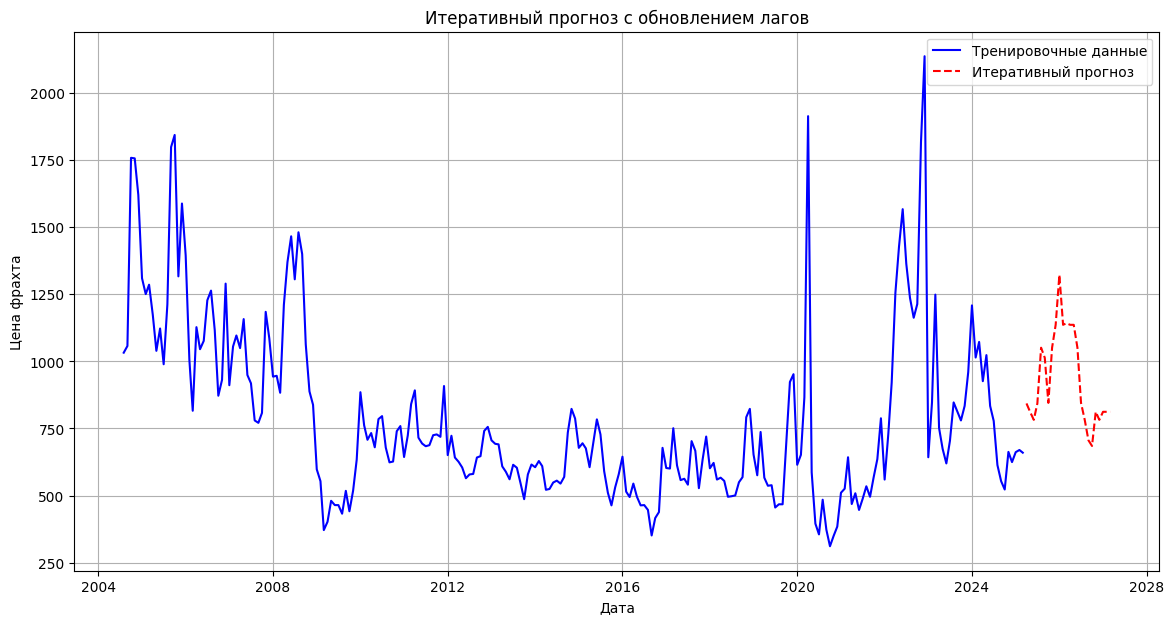

In [18]:
# Итеративное предсказание с обновлением лагов, используя ваши столбцы
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

forecast_horizon = 24  # период прогнозирования

# Используем последние данные из df_train для инициализации
last_date = df_train.index[-1]
freight_history = list(y[-24:])           
last_oil = df_train.iloc[-1]['Oil_Price']
last_war = df_train.iloc[-1]['has_war']      # добавлено
last_crisis = df_train.iloc[-1]['has_crisis']  # добавлено

iterative_predictions = []
current_date = last_date

for i in range(forecast_horizon):
    freight_t1  = freight_history[-1]
    freight_t6  = freight_history[-6]  if len(freight_history) >= 6  else freight_history[0]
    freight_t12 = freight_history[-12] if len(freight_history) >= 12 else freight_history[0]
    freight_t24 = freight_history[-24] if len(freight_history) >= 24 else freight_history[0]
    
    # вычисляем следующую дату (прибавляем месяц)
    current_date = (current_date + pd.DateOffset(months=1)).to_pydatetime()
    month = current_date.month
    new_features = {
        'month_sin': np.sin(2 * np.pi * month / 12),
        'month_cos': np.cos(2 * np.pi * month / 12),
        'Freight_Price(t-1)': freight_t1,
        'Freight_Price(t-6)': freight_t6,
        'Freight_Price(t-12)': freight_t12,
        'Freight_Price(t-24)': freight_t24,
        'Oil_Price': last_oil,
        'Oil_Price(t-1)': last_oil,
        'Oil_Price(t-6)': last_oil,
        'Oil_Price(t-12)': last_oil,
        'Oil_Price(t-24)': last_oil,
        'has_war': last_war,          # добавлено
        'has_crisis': last_crisis     # добавлено
    }
    new_X = pd.DataFrame([new_features], index=[current_date])
    
    # Итеративное предсказание
    pred = best_lgb3.predict(new_X)[0]
    iterative_predictions.append(pred)
    freight_history.append(pred)

forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')
forecast_series = pd.Series(iterative_predictions, index=forecast_dates)
print("Итеративный прогноз:")
print(forecast_series)

plt.figure(figsize=(14, 7))
plt.plot(df_train.index, y, label='Тренировочные данные', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Итеративный прогноз', color='red', linestyle='--')
plt.title('Итеративный прогноз с обновлением лагов')
plt.xlabel('Дата')
plt.ylabel('Цена фрахта')
plt.legend()
plt.grid(True)
plt.show()

Итеративный прогноз для тестового периода 2023-2025:
2023-05-01     843.208058
2023-06-01     812.076145
2023-07-01     782.190412
2023-08-01     843.208058
2023-09-01    1050.599397
2023-10-01    1013.072247
2023-11-01     845.269035
2023-12-01    1050.599397
2024-01-01    1135.730538
2024-02-01    1321.669737
2024-03-01    1135.730538
2024-04-01    1141.660038
2024-05-01    1135.730538
2024-06-01    1135.730538
2024-07-01    1050.599397
2024-08-01     845.269035
2024-09-01     782.190412
2024-10-01     706.197683
2024-11-01     685.006064
2024-12-01     812.076145
2025-01-01     782.190412
2025-02-01     812.076145
2025-03-01     812.076145
2025-04-01     812.076145
Freq: MS, dtype: float64


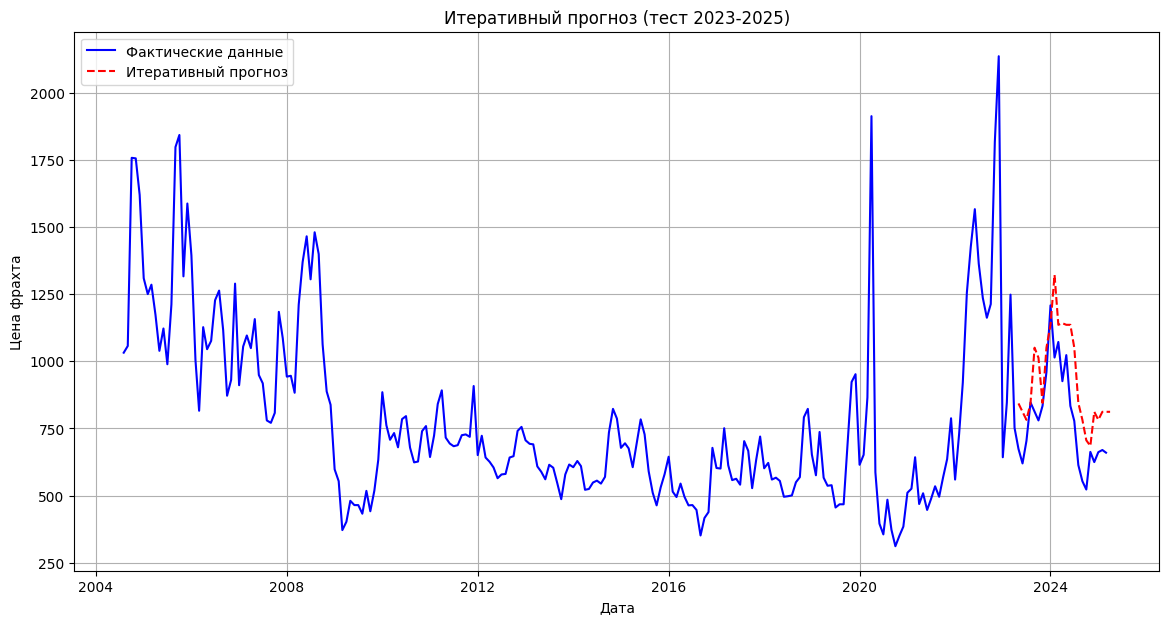

In [19]:
# Итеративное предсказание для тестового периода 2023-2025
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Используем X_test для определения тестового периода
forecast_horizon = len(X_test)  # число месяцев в тестовой выборке
last_date = X_test.index[0]     # первая дата тестовой выборки
# Инициализируем историю, используя последние 24 значений из тренировочного набора y
freight_history = list(y[-24:])
last_oil = df_train.iloc[-1]['Oil_Price']
last_war = df_train.iloc[-1]['has_war']      # добавлено
last_crisis = df_train.iloc[-1]['has_crisis']  # добавлено

iterative_predictions = []
current_date = last_date

for i in range(forecast_horizon):
    freight_t1  = freight_history[-1]
    freight_t6  = freight_history[-6] if len(freight_history) >= 6 else freight_history[0]
    freight_t12 = freight_history[-12] if len(freight_history) >= 12 else freight_history[0]
    freight_t24 = freight_history[-24] if len(freight_history) >= 24 else freight_history[0]
    
    current_date = (current_date + pd.DateOffset(months=1)).to_pydatetime()
    month = current_date.month
    new_features = {
        'month_sin': np.sin(2 * np.pi * month / 12),
        'month_cos': np.cos(2 * np.pi * month / 12),
        'Freight_Price(t-1)': freight_t1,
        'Freight_Price(t-6)': freight_t6,
        'Freight_Price(t-12)': freight_t12,
        'Freight_Price(t-24)': freight_t24,
        'Oil_Price': last_oil,
        'Oil_Price(t-1)': last_oil,
        'Oil_Price(t-6)': last_oil,
        'Oil_Price(t-12)': last_oil,
        'Oil_Price(t-24)': last_oil,
        'has_war': last_war,          # добавлено
        'has_crisis': last_crisis     # добавлено
    }
    new_X = pd.DataFrame([new_features], index=[current_date])
    pred = best_lgb3.predict(new_X)[0]
    iterative_predictions.append(pred)
    freight_history.append(pred)

forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')
forecast_series = pd.Series(iterative_predictions, index=forecast_dates)
print("Итеративный прогноз для тестового периода 2023-2025:")
print(forecast_series)

plt.figure(figsize=(14, 7))
plt.plot(y.index, y, label='Фактические данные', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Итеративный прогноз', color='red', linestyle='--')
plt.title('Итеративный прогноз (тест 2023-2025)')
plt.xlabel('Дата')
plt.ylabel('Цена фрахта')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Добавляем расчет метрик и оформление графика как на фото
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, forecast_series)
mse = mean_squared_error(y_test, forecast_series)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, forecast_series)

plt.figure(figsize=(14,7))
plt.plot(X_test.index, y_test, 'o-', markersize=6, color='blue', label='Фактические данные')
plt.plot(forecast_series.index, forecast_series, 's--', markersize=6, color='red', label='Прогноз')
plt.title('Итеративный прогноз (тест 2023-2025)')
plt.xlabel('Дата')
plt.ylabel('Цена фрахта')
plt.grid(True)
plt.legend()
plt.text(0.05, 0.95, f'MAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nR2: {r2:.2f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.show()

print("Метрики:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

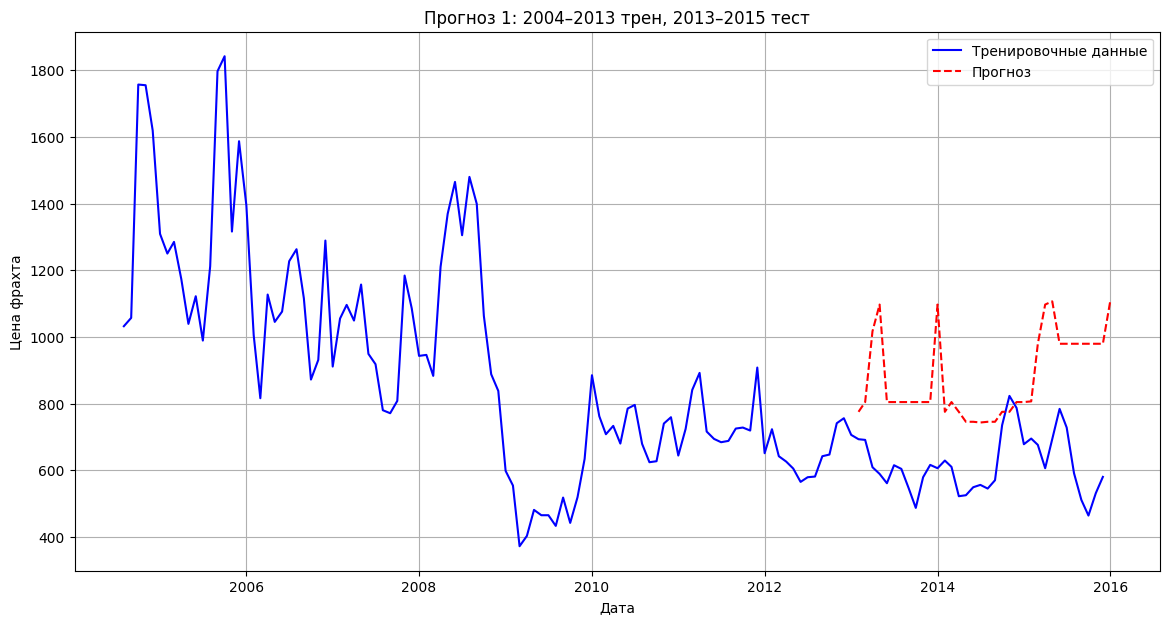

Прогноз 1 метрики:
MAE: 259.9550771649297
MSE: 87737.20391088244
RMSE: 296.20466557919445
R2: -10.74284538867302


In [62]:
# Итеративное предсказание с обновлением лагов, используя ваши столбцы
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

forecast_horizon = 24  # период прогнозирования

# Фильтрация данных по датам
huy = df_train.loc['2004-01-01':'2015-12-01']
huy = huy['Freight_Price']
train_period = df_train.loc['2004-01-01':'2012-12-01']
test_period  = df_train.loc['2013-01-01':'2015-12-01']
forecast_horizon = len(test_period)
last_date = test_period.index[0]
# Используем последние 24 значения из тренировочного множества (удостоверьтесь, что их достаточно)
freight_history = list(train_period['Freight_Price'][-24:])
last_oil = train_period.iloc[-1]['Oil_Price']

iterative_predictions = []
current_date = last_date

# Итеративный прогноз без дополнительных фич (has_war/has_crisis не используются в этом файле)
for i in range(forecast_horizon):
    freight_t1  = freight_history[-1]
    freight_t6  = freight_history[-6] if len(freight_history) >= 6 else freight_history[0]
    freight_t12 = freight_history[-12] if len(freight_history) >= 12 else freight_history[0]
    freight_t24 = freight_history[-24] if len(freight_history) >= 24 else freight_history[0]
    
    current_date = (current_date + pd.DateOffset(months=1)).to_pydatetime()
    month = current_date.month
    new_features = {
        'month_sin': np.sin(2 * np.pi * month / 12),
        'month_cos': np.cos(2 * np.pi * month / 12),
        'Freight_Price(t-1)': freight_t1,
        'Freight_Price(t-6)': freight_t6,
        'Freight_Price(t-12)': freight_t12,
        'Freight_Price(t-24)': freight_t24,
        'Oil_Price': last_oil,
        'Oil_Price(t-1)': last_oil,
        'Oil_Price(t-6)': last_oil,
        'Oil_Price(t-12)': last_oil,
        'Oil_Price(t-24)': last_oil,
        'has_war': train_period.iloc[-1]['has_war'],       # добавлено
        'has_crisis': train_period.iloc[-1]['has_crisis']    # добавлено
    }
    new_X = pd.DataFrame([new_features], index=[current_date])
    pred = best_lgb3.predict(new_X)[0]
    iterative_predictions.append(pred)
    freight_history.append(pred)
    
forecast_series = pd.Series(iterative_predictions, index=pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS'))

# Расчет метрик
mae_1 = mean_absolute_error(test_period['Freight_Price'], forecast_series)
mse_1 = mean_squared_error(test_period['Freight_Price'], forecast_series)
rmse_1 = np.sqrt(mse_1)
r2_1 = r2_score(test_period['Freight_Price'], forecast_series)

plt.figure(figsize=(14,7))
plt.plot(huy.index, huy, label='Тренировочные данные', color='blue')
# plt.plot(test_period.index, test_period['Freight_Price'], label='Фактические данные (тест)', color='green')
plt.plot(forecast_series.index, forecast_series, label='Прогноз', color='red', linestyle='--')
plt.title('Прогноз 1: 2004–2013 трен, 2013–2015 тест')
plt.xlabel('Дата')
plt.ylabel('Цена фрахта')
plt.grid(True)
plt.legend()
# plt.text(0.05, 0.95, f'MAE: {mae_1:.2f}\nMSE: {mse_1:.2f}\nRMSE: {rmse_1:.2f}\nR2: {r2_1:.2f}', 
        #  transform=plt.gca().transAxes, verticalalignment='top',
        #  bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.show()

print("Прогноз 1 метрики:")
print(f"MAE: {mae_1}")
print(f"MSE: {mse_1}")
print(f"RMSE: {rmse_1}")
print(f"R2: {r2_1}")

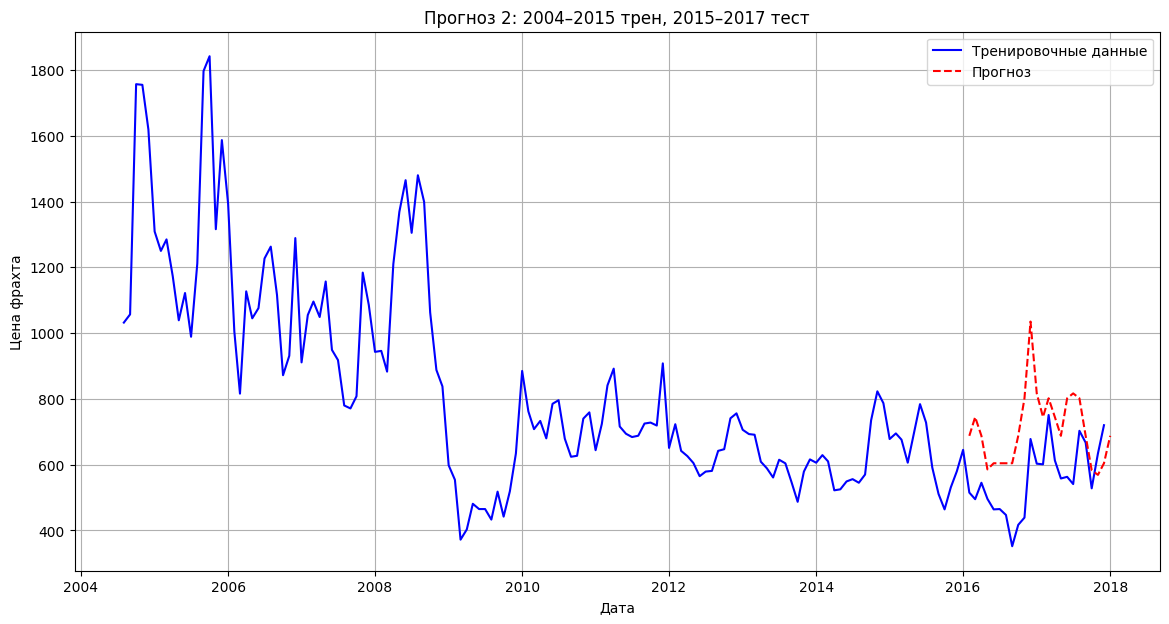

Прогноз 1 метрики:
MAE: 162.10491775966958
MSE: 44718.945133354086
RMSE: 211.4685440753638
R2: -3.3228289613192503


In [63]:
forecast_horizon = 24  # период прогнозирования

# Фильтрация данных по датам
huy = df_train.loc['2004-01-01':'2017-12-01']
huy = huy['Freight_Price']
train_period = df_train.loc['2004-01-01':'2015-12-01']
test_period  = df_train.loc['2016-01-01':'2017-12-01']
forecast_horizon = len(test_period)
last_date = test_period.index[0]
# Используем последние 24 значения из тренировочного множества (удостоверьтесь, что их достаточно)
freight_history = list(train_period['Freight_Price'][-24:])
last_oil = train_period.iloc[-1]['Oil_Price']

iterative_predictions = []
current_date = last_date

# Итеративный прогноз без дополнительных фич (has_war/has_crisis не используются в этом файле)
for i in range(forecast_horizon):
    freight_t1  = freight_history[-1]
    freight_t6  = freight_history[-6] if len(freight_history) >= 6 else freight_history[0]
    freight_t12 = freight_history[-12] if len(freight_history) >= 12 else freight_history[0]
    freight_t24 = freight_history[-24] if len(freight_history) >= 24 else freight_history[0]
    
    current_date = (current_date + pd.DateOffset(months=1)).to_pydatetime()
    month = current_date.month
    new_features = {
        'month_sin': np.sin(2 * np.pi * month / 12),
        'month_cos': np.cos(2 * np.pi * month / 12),
        'Freight_Price(t-1)': freight_t1,
        'Freight_Price(t-6)': freight_t6,
        'Freight_Price(t-12)': freight_t12,
        'Freight_Price(t-24)': freight_t24,
        'Oil_Price': last_oil,
        'Oil_Price(t-1)': last_oil,
        'Oil_Price(t-6)': last_oil,
        'Oil_Price(t-12)': last_oil,
        'Oil_Price(t-24)': last_oil,
        'has_war': train_period.iloc[-1]['has_war'],       # добавлено
        'has_crisis': train_period.iloc[-1]['has_crisis']    # добавлено
    }
    new_X = pd.DataFrame([new_features], index=[current_date])
    pred = best_lgb3.predict(new_X)[0]
    iterative_predictions.append(pred)
    freight_history.append(pred)
    
forecast_series = pd.Series(iterative_predictions, index=pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS'))

# Расчет метрик
mae_1 = mean_absolute_error(test_period['Freight_Price'], forecast_series)
mse_1 = mean_squared_error(test_period['Freight_Price'], forecast_series)
rmse_1 = np.sqrt(mse_1)
r2_1 = r2_score(test_period['Freight_Price'], forecast_series)

plt.figure(figsize=(14,7))
plt.plot(huy.index, huy, label='Тренировочные данные', color='blue')
# plt.plot(test_period.index, test_period['Freight_Price'], label='Фактические данные (тест)', color='green')
plt.plot(forecast_series.index, forecast_series, label='Прогноз', color='red', linestyle='--')
plt.title('Прогноз 2: 2004–2015 трен, 2015–2017 тест')
plt.xlabel('Дата')
plt.ylabel('Цена фрахта')
plt.grid(True)
plt.legend()
# plt.text(0.05, 0.95, f'MAE: {mae_1:.2f}\nMSE: {mse_1:.2f}\nRMSE: {rmse_1:.2f}\nR2: {r2_1:.2f}', 
        #  transform=plt.gca().transAxes, verticalalignment='top',
        #  bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.show()

print("Прогноз 1 метрики:")
print(f"MAE: {mae_1}")
print(f"MSE: {mse_1}")
print(f"RMSE: {rmse_1}")
print(f"R2: {r2_1}")